## MOFAtalk

In [1]:
import os

In [2]:
data_dir = os.path.join('..', '..', 'data', 'kidney_injury')

In [3]:
# columns of interest
sample_key = "ident"
groupby = "cell_type"
condition_key = "Group"

## Setup Environment

In [4]:
import numpy as np
import pandas as pd

import scanpy as sc

In [5]:
import mofax as mofa
import muon as mu
import decoupler as dc

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import liana as li
import plotnine as p9

In [7]:
li.__version__

'0.1.9'

Load object

In [ ]:
adata = sc.read_h5ad(os.path.join(data_dir, "aki_processed.h5ad"))

In [ ]:
adata.obs.sort_values("cell_type")

In [ ]:
adata.obs[groupby].value_counts()

In [ ]:
adata.uns.keys()

## Run LIANA

In [ ]:
li.method.rank_aggregate.by_sample(adata,
                                   groupby=groupby,
                                   sample_key=sample_key,
                                   resource_name='mouseconsensus',
                                   use_raw=False,
                                   verbose=True,
                                   n_perms=None,
                                   return_all_lrs=False
                                   )

In [ ]:
adata.write_h5ad(os.path.join(data_dir, "aki_processed.h5ad"))

In [ ]:
adata.uns['liana_res']['ident'].nunique()

## Run MOFA

In [8]:
adata = sc.read_h5ad(os.path.join(data_dir, "aki_processed.h5ad"))

In [9]:
score_key = 'magnitude_rank'

In [10]:
mdata = li.multi.lrs_to_views(adata,
                              sample_key=sample_key,
                              score_key=score_key,
                              obs_keys=[condition_key], # add those to mdata.obs
                              lr_prop = 0.25, # minimum required proportion of samples to keep an LR
                              lrs_per_sample = 15, # minimum number of interactions to keep a sample in a specific view
                              lrs_per_view = 25, # minimum number of interactions to keep a view
                              samples_per_view = 5, # minimum number of samples to keep a view
                              min_variance = 0, # minimum variance to keep an interaction
                              lr_fill = np.nan, # fill missing LR values across samples with this
                              verbose=True
                              )

100%|██████████| 159/159 [00:01<00:00, 137.87it/s]


In [11]:
mu.tl.mofa(mdata,
           use_obs='union',
           convergence_mode='medium',
           outfile='models/mofatalk.h5ad',
           n_factors=5,
           )


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='PEC&CTAL' group='group1' with N=24 samples and D=17 features...
Loaded view='PEC&MTAL' group='group1' with N=24 samples and D=29 features...
Loaded view='PEC&Per' group='group1' with N=24 samples and D=47 features...
Loaded view='PEC&PC' group='group1' with N=24 samples and D=22 features...
Loaded view='PEC&ICB' group='group1' with N=24 samples and D=18 features...


In [12]:
# obtain factor scores
factor_scores = li.multi.get_factor_scores(mdata, obsm_key='X_mofa')
# re-order Groups
factor_scores['Group'] = factor_scores['Group'].astype('category')
factor_scores['Group'] = factor_scores['Group'].cat.reorder_categories(['Control', '4hours','12hours',  '2days', '14days', '6weeks'])
factor_scores.head()

,ident,Factor1,Factor2,Factor3,Factor4,Factor5,Group
0,IRI12h1b1,0.212758,-0.018611,-0.015426,-0.009003,0.002567,12hours
1,IRI12h1b2,0.205543,-0.019785,-0.014341,-0.009589,0.002848,12hours
2,IRI12h2,0.212398,-0.017152,-0.013336,-0.009206,0.002272,12hours
3,IRI12h3,0.199433,-0.019083,-0.015480,-0.008798,0.002676,12hours
4,IRI14d1b1,-0.106828,-0.020529,-0.014913,-0.010607,0.001289,14days


UMAP

In [13]:
sc.pp.neighbors(mdata, use_rep="X_mofa")
sc.tl.umap(mdata)

sc.tl.umap(mdata, min_dist=.2, spread=1., random_state=10)

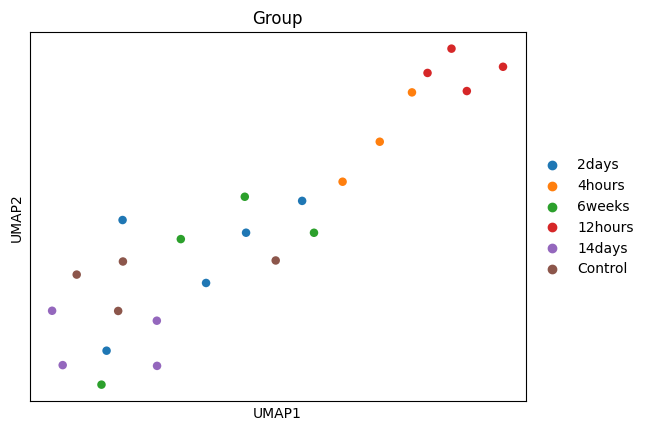

In [14]:
sc.pl.umap(mdata, color="Group", size=150)

In [15]:
# Kruskal Wallis test
from scipy.stats import kruskal

In [16]:
# Extract the values for each group
groups = []
for group_name, group_data in factor_scores.groupby('Group'):
    groups.append(group_data['Factor1'].values)

# Perform the Kruskal-Wallis test
statistic, p_value = kruskal(*groups)

# Print the test results
print("Kruskal-Wallis Test")
print("Statistic:", statistic)
print("P-value:", p_value)

Kruskal-Wallis Test
Statistic: 17.310000000000002
P-value: 0.00394789398713399


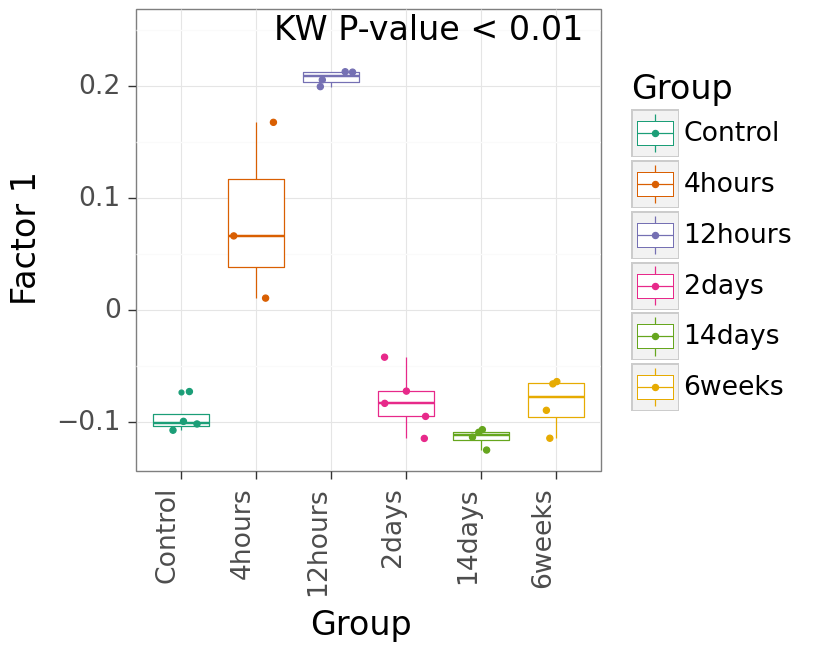

<ggplot: (8742949373628)>

In [17]:
# scatterplot
(p9.ggplot(factor_scores) +
 p9.aes(x='Group', colour='Group', y='Factor1') +
 p9.geom_boxplot() +
 p9.geom_jitter(size=2, width=0.3) +
 p9.theme_bw(base_size=24) +
 p9.theme(figure_size=(6, 6)) + 
 p9.labs(x='Group', y='Factor 1') +
 # rotate x-axis labels
 p9.theme(axis_text_x=p9.element_text(angle=90, hjust=1)) +
 # Dark2 set 
 p9.scale_color_brewer(type='qual', palette='Dark2') +
 # add p-value to top-right
 p9.annotate('text', x=4.3, y=0.25, label=f'KW P-value < {np.ceil(p_value * 100) / 100}', size=24)
 
 )

Plot R-sq

In [18]:
model = mofa.mofa_model("models/mofatalk.h5ad")
model

MOFA+ model: mofatalk.h5ad
Samples (cells): 24
Features: 2699
Groups: group1 (24)
Views: CNT&DTL-ATL (20), CNT&Fib (26), CNT&PEC (34), CNT&PT (18), CNT&Per (17), CNT&Pod (24), CNT&Uro (29), CTAL&DTL-ATL (18), CTAL&Fib (22), CTAL&PEC (27), CTAL&PT (16), CTAL&Per (15), CTAL&Pod (17), CTAL&Uro (25), DCT&DTL-ATL (21), DCT&Fib (22), DCT&PEC (25), DCT&PT (14), DCT&Per (12), DCT&Pod (21), DCT&Uro (24), DCT-CNT&Fib (25), DCT-CNT&PEC (28), DCT-CNT&Pod (17), DCT-CNT&Uro (32), DTL-ATL&DTL-ATL (18), DTL-ATL&Fib (23), DTL-ATL&PEC (32), DTL-ATL&PT (17), DTL-ATL&Per (23), DTL-ATL&Pod (23), DTL-ATL&Uro (31), EC&Fib (13), EC&PEC (9), EC&Per (6), EC&Pod (15), EC&Uro (15), Fib&DCT-CNT (14), Fib&DTL-ATL (27), Fib&Fib (42), Fib&MTAL (17), Fib&PEC (44), Fib&PT (25), Fib&Per (33), Fib&Pod (40), Fib&Uro (49), ICA&Fib (15), ICA&Pod (15), ICA&Uro (17), ICB&Fib (21), ICB&PEC (24), ICB&Pod (15), ICB&Uro (24), MTAL&DTL-ATL (15), MTAL&Fib (26), MTAL&PEC (19), MTAL&PT (17), MTAL&Per (15), MTAL&Uro (23), PC&DTL-ATL (

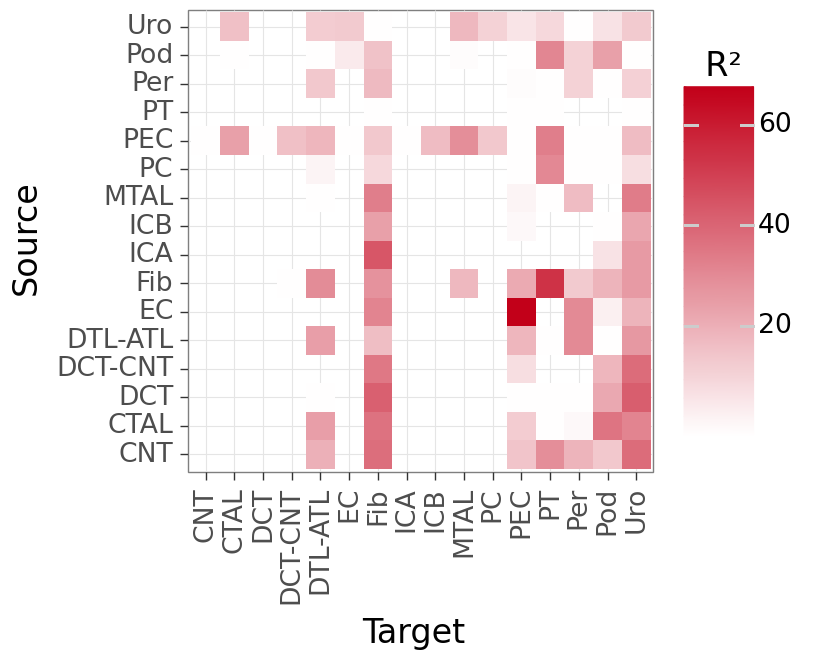

<ggplot: (8742948587638)>

In [19]:
# get variance explained by view and factor
rsq = model.get_r2()
factor1_rsq = rsq[rsq['Factor']=='Factor1']
# separate view column
factor1_rsq[['source', 'target']] = factor1_rsq['View'].str.split('&', 1, expand=True)

(p9.ggplot(factor1_rsq.reset_index()) +
 p9.aes(x='target', y='source') +
 p9.geom_tile(p9.aes(fill='R2')) +
 p9.scale_fill_gradient2(low='white', high='#c20019') +
 p9.theme_bw(base_size=24) +
 # rotate X axis
 p9.theme(axis_text_x=p9.element_text(angle=90), figure_size=(6, 6)) +
 p9.labs(x='Target', y='Source', fill='  R²')
 )

In [20]:
sources = np.unique(factor1_rsq.sort_values("R2", ascending=False)['source'].head(10).values)
sources

array(['CNT', 'CTAL', 'DCT', 'DCT-CNT', 'EC', 'Fib', 'ICA'], dtype=object)

In [21]:
targets = np.unique(factor1_rsq.sort_values("R2", ascending=False)['target'].head(10).values)
targets

array(['Fib', 'PEC', 'PT', 'Pod', 'Uro'], dtype=object)

Average R2 per source & target

In [22]:
# mean R2 and std for factor1
factor1_rsq.groupby('target').agg({'R2': ['mean', 'std']}).sort_values(('R2', 'mean'), ascending=False).head(10)

R2           
              mean        std
target                       
Fib      23.996381  13.808916
Uro      22.183097  12.946500
ICB      17.107415        NaN
MTAL     16.630942  11.757348
PT       15.584820  18.597953
CTAL     13.667581  12.502867
DTL-ATL  13.531879  11.188478
PC       12.933593   1.650043
Per      11.331436  11.278984
Pod      10.949058  11.568095

In [23]:
# mean R2 and std for factor1
factor1_rsq.groupby('source').agg({'R2': ['mean', 'std']}).sort_values(('R2', 'mean'), ascending=False).head(10)

R2           
              mean        std
source                       
EC       30.080890  22.852060
ICA      25.527268  17.924832
DCT-CNT  24.857433  13.816847
CNT      24.767081  10.019861
Fib      23.189205  14.110177
CTAL     20.555778  15.498901
DTL-ATL  16.793770  12.276723
DCT      15.011266  19.759644
MTAL     14.486484  15.934848
ICB      12.231689  13.179260

In [24]:
factor1_rsq['R2'].mean()

14.964781224364726

In [25]:
factor1_rsq.sort_values("R2", ascending=False).head(10)

,Factor,View,Group,R2,source,target
105,Factor1,EC&PEC,group1,65.830353,EC,PEC
43,Factor1,Fib&PT,group1,52.517755,Fib,PT
35,Factor1,ICA&Fib,group1,43.223214,ICA,Fib
34,Factor1,DCT&Uro,group1,41.600140,DCT,Uro
88,Factor1,DCT&Fib,group1,41.113374,DCT,Fib
60,Factor1,CNT&Uro,group1,37.973097,CNT,Uro
40,Factor1,DCT-CNT&Uro,group1,37.876830,DCT-CNT,Uro
73,Factor1,CNT&Fib,group1,37.323708,CNT,Fib
45,Factor1,CTAL&Fib,group1,36.225895,CTAL,Fib
14,Factor1,CTAL&Pod,group1,35.635192,CTAL,Pod


In [26]:
adata.obs[[groupby, "full_name"]].drop_duplicates()

,cell_type,full_name
IRI4h1_AAACCTGAGATCTGCT,CTAL,Thick ascending limb of loop of Henle
IRI4h1_AAACCTGAGATTACCC,PT,Proximal tubule
IRI4h1_AAACCTGAGTGTTAGA,EC,Epithelial cells
IRI4h1_AAACCTGCACCAACCG,DCT,Distal convoluted tubule
IRI4h1_AAACCTGCAGCCTGTG,MTAL,medullary thick ascending limb
IRI4h1_AAACCTGCAGGGAGAG,ICA,Intercalated cell of collecting duct
IRI4h1_AAACCTGGTAGCGCTC,Fib,Fibroblast
IRI4h1_AAACCTGTCGTCGTTC,DCT-CNT,DCT-CNT
IRI4h1_AAACGGGAGCATGGCA,MO,Macrophages
IRI4h1_AAACGGGGTGCAACGA,PC,Principal cells


In [27]:
variable_loadings =  li.multi.get_variable_loadings(mdata,
                                                    view_separator=':',
                                                    pair_separator="&",
                                                    variable_separator="^") # get loadings for factor 1
variable_loadings.head()
variable_loadings['size'] = 3

In [28]:
# convert to abs to order
variable_loadings['abs_F1'] = np.abs(variable_loadings['Factor1'])

In [29]:
variable_loadings

,ligand_complex,receptor_complex,source,target,Factor1,Factor2,Factor3,Factor4,Factor5,size,abs_F1
1827,Slit2,Robo2,CNT,Fib,-3.171660e+00,2.232469e-01,2.771807e-02,2.575472e-01,5.480457e-03,3,3.171660e+00
2189,Slit2,Robo2,DCT,Fib,-3.145700e+00,9.944637e-01,2.801997e-02,3.552442e-01,-3.127553e-03,3,3.145700e+00
1015,Slit2,Robo1,DCT-CNT,Uro,-3.137715e+00,-1.707674e+00,2.484156e-02,1.329919e-01,-2.035385e-02,3,3.137715e+00
880,Slit2,Robo1,DCT,Uro,-3.065370e+00,-3.426198e+00,5.316154e-02,-1.544281e-01,-4.007918e-01,3,3.065370e+00
1517,Slit2,Robo1,CNT,Uro,-3.063561e+00,-2.986251e+00,1.262222e-01,-2.157707e-02,-2.040984e-03,3,3.063561e+00
...,...,...,...,...,...,...,...,...,...,...,...
105,Ncam1,Fgfr2,PEC,PC,1.760351e-08,-7.865487e-07,4.785977e-07,2.283598e-06,2.165554e-04,3,1.760351e-08
34,Ncam1,Fgfr2,PEC,MTAL,1.297025e-08,5.434666e-08,4.216069e-07,1.393479e-07,2.281348e-06,3,1.297025e-08
142,Ncam1,Fgfr2,PEC,CNT,-5.904578e-09,2.390934e-09,-3.833425e-10,-1.726687e-09,3.687514e-09,3,5.904578e-09
380,Ncam1,Fgfr2,PEC,ICA,-3.824532e-09,3.803731e-09,4.252819e-09,-6.738662e-09,1.073922e-07,3,3.824532e-09


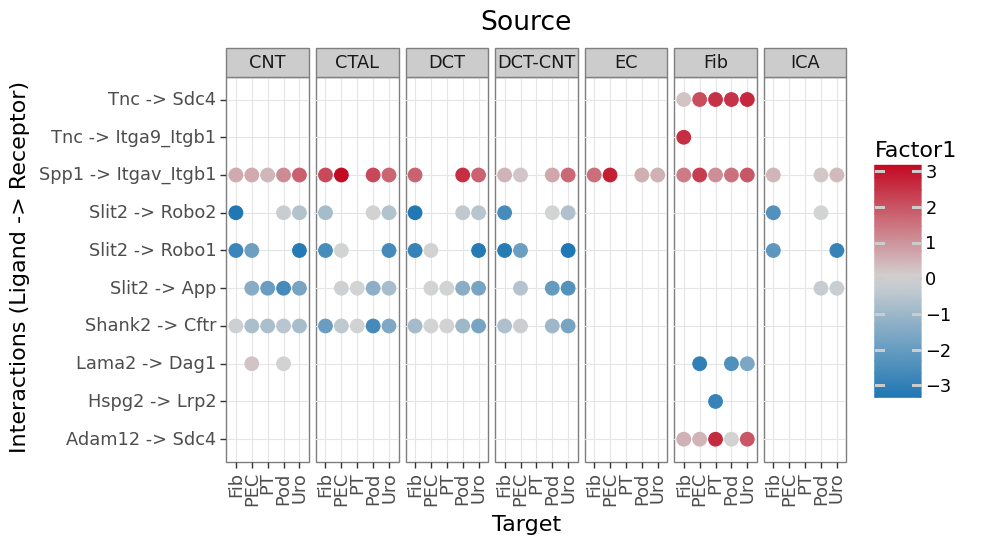

<ggplot: (8742948821761)>

In [30]:
my_plot = li.pl.dotplot(liana_res = variable_loadings,
                        size='size',
                        colour='Factor1',
                        orderby='abs_F1',
                        top_n=10,
                        source_labels=sources,
                        target_labels=targets,
                        orderby_ascending=False,
                        size_range=(0.1, 5),
                        figure_size=(6, 8)
                        )
# change colour, with mid as white
(my_plot + 
 p9.scale_color_gradient2(low='#1f77b4', mid='lightgray', high='#c20019') + 
 p9.theme_bw(base_size=16) +
 p9.theme(figure_size=(8, 5)) +
p9.theme(axis_text_x=p9.element_text(angle=90)) +
 # remove size from legend
 p9.guides(size=False)
)

Pathway enrichment

In [35]:
lr_loadings =  li.multi.get_variable_loadings(mdata,
                                              view_separator=':',
                                              )
lr_loadings.set_index('variable', inplace=True)

In [36]:
lr_loadings.to_csv(os.path.join(data_dir, 'lr_loadings.csv'))

In [37]:
# load PROGENy pathways
net = dc.get_progeny(organism='Mus musculus', top=5000)
# load full list of ligand-receptor pairs
lr_pairs = li.resource.select_resource('mouseconsensus')

# generate ligand-receptor geneset
lr_progeny = li.fun.generate_lr_geneset(lr_pairs, net, lr_separator="^")
lr_progeny.head()

,source,interaction,weight
1,EGFR,Dll1^Notch1,-1.000584
31,EGFR,Adam10^Notch1,-0.924934
37,MAPK,Adam10^Notch1,-0.925038
58,WNT,Tnf^Notch1,-1.513049
98,WNT,Adam17^Notch1,-0.951469


In [34]:
# NOTE: should instead do enrichment for each view separately?
# here, I'm inflating the number of targets per pathway, e.g. it could be that a line is fit between 2 interactions...

# pivot views to wide
lr_loadings = lr_loadings.pivot(columns='view', values='Factor1')


In [ ]:
# replace NaN with 0
lr_loadings.replace(np.nan, 0, inplace=True)

In [38]:
lr_loadings.reset_index(inplace=True)

In [43]:
lr_loadings['view'].unique()

array(['CNT&Fib', 'DCT&Fib', 'DCT-CNT&Uro', 'DCT&Uro', 'CNT&Uro',
       'DCT-CNT&Fib', 'CTAL&PEC', 'CNT&Per', 'Pod&Pod', 'ICB&Uro',
       'Fib&PEC', 'CTAL&DTL-ATL', 'ICA&Uro', 'Fib&PT', 'EC&PEC', 'PC&PT',
       'DTL-ATL&Per', 'Pod&Fib', 'Per&Fib', 'Fib&DTL-ATL', 'Per&Uro',
       'PEC&MTAL', 'Fib&Uro', 'PEC&PC', 'MTAL&Uro', 'CTAL&Pod',
       'CTAL&Uro', 'CNT&Pod', 'Uro&Pod', 'Fib&Fib', 'DCT&Pod', 'CTAL&Fib',
       'DTL-ATL&DTL-ATL', 'PEC&PT', 'Per&Per', 'Fib&Pod', 'DTL-ATL&Uro',
       'PEC&CTAL', 'Per&DTL-ATL', 'Uro&DTL-ATL', 'ICA&Fib', 'ICB&Fib',
       'PEC&Uro', 'CNT&DTL-ATL', 'PEC&DTL-ATL', 'MTAL&Fib', 'EC&Per',
       'DTL-ATL&PEC', 'Uro&PC', 'PEC&ICB', 'DTL-ATL&Fib', 'Pod&Per',
       'PEC&Fib', 'Uro&EC', 'DCT-CNT&Pod', 'Uro&Uro', 'CNT&PT',
       'DCT-CNT&PEC', 'EC&Fib', 'CNT&PEC', 'Uro&PEC', 'Pod&PT', 'PC&Fib',
       'MTAL&Per', 'PC&Uro', 'Fib&Per', 'Uro&MTAL', 'Fib&MTAL', 'Uro&PT',
       'PEC&DCT-CNT', 'EC&Uro', 'Uro&CTAL', 'ICA&Pod', 'EC&Pod', 'Pod&EC',
       'MTAL&P

In [65]:
view_enrichments = {}

In [66]:
for view in lr_loadings['view'].unique():
    mat = lr_loadings.loc[lr_loadings['view']==view, ['variable','Factor1']].set_index("variable").transpose()
    try:
        
        estimate, _ = dc.run_ulm(mat, lr_progeny,
                   source="source", target="interaction",
                   use_raw=False, min_n=5)
        view_enrichments[view] = estimate
    except:
        print("Not enough interactions:", view)
        continue


Not enough interactions: CNT&Fib
Not enough interactions: DCT&Fib
Not enough interactions: DCT&Uro
Not enough interactions: DCT-CNT&Fib
Not enough interactions: CTAL&PEC
Not enough interactions: CNT&Per
Not enough interactions: Pod&Pod
Not enough interactions: CTAL&DTL-ATL
Not enough interactions: ICA&Uro
Not enough interactions: Fib&PT
Not enough interactions: EC&PEC
Not enough interactions: PC&PT
Not enough interactions: DTL-ATL&Per
Not enough interactions: Pod&Fib
Not enough interactions: Per&Uro
Not enough interactions: PEC&PC
Not enough interactions: CTAL&Pod
Not enough interactions: CNT&Pod
Not enough interactions: Uro&Pod
Not enough interactions: DCT&Pod
Not enough interactions: CTAL&Fib
Not enough interactions: DTL-ATL&DTL-ATL
Not enough interactions: PEC&PT
Not enough interactions: PEC&CTAL
Not enough interactions: Per&DTL-ATL
Not enough interactions: Uro&DTL-ATL
Not enough interactions: CNT&DTL-ATL
Not enough interactions: MTAL&Fib
Not enough interactions: EC&Per
Not enough i

In [ ]:
# run pathway enrichment analysis
estimate, pvals =  dc.run_ulm(lr_loadings.transpose(), lr_progeny,
                              source="source", target="interaction",
                              use_raw=False, min_n=5)
# pivot columns to long
estimate = (estimate.
            melt(ignore_index=False, value_name='estimate', var_name='pathway').
            reset_index().
            rename(columns={'index':'view'})
            )


In [ ]:
# estimate[['source', 'target']] = estimate['view'].str.split('&', 1, expand=True)
# # source in sources, and target in targets
# estimate = estimate[(estimate['source'].isin(sources)) & (estimate['target'].isin(targets))]

In [ ]:
estimate.loc[estimate['estimate'] > 5, "estimate"]=5 
estimate.loc[estimate['estimate'] < -5, "estimate"]=-5

In [ ]:
## p9 tile plot
(p9.ggplot(estimate) +
 p9.aes(x='pathway', y='view') +
 p9.geom_tile(p9.aes(fill='estimate')) +
 p9.scale_fill_gradient2(low='#1f77b4', high='#c20019') +
 p9.theme_bw(base_size=14) +
 p9.theme(figure_size=(10, 20))
 # max fill value = 5
)


Explore loadings x PROGENy, for a specific view

In [ ]:
factor1_rsq.sort_values("R2", ascending=False).head(10)

In [ ]:
# pivot to long
lr_loadings = lr_loadings.melt(ignore_index=False, value_name='loading', var_name='view').reset_index()

In [ ]:
lr_loadings.rename(columns={'variable':'interaction'}, inplace=True)

In [ ]:
lr_loadings

In [ ]:
lr_loadings = lr_loadings.merge(lr_progeny.rename(columns={"source":"pathway"}), left_on='interaction', right_on='interaction', how='left').dropna()

In [ ]:
lr_loadings['sign'] = lr_loadings['weight'].apply(lambda x: 'positive' if x > 0 else 'negative')

In [ ]:
lr_loadings['relevant_interactions'] = lr_loadings.apply(lambda x: x['interaction'] if (np.abs(x['loading']) > 0) and (np.abs(x['weight']) >= 0.5) else None, axis=1)

In [ ]:
### plot fibpod, weight on x, estimate on y

In [ ]:
selected_pathway = 'NFkB'
selected_view = 'Fib&PT'


In [ ]:
data = lr_loadings[(lr_loadings['pathway']==selected_pathway) & (lr_loadings['view']==selected_view)].copy()

In [ ]:
data.sort_values('relevant_interactions', ascending=False)

In [ ]:
estimate[estimate['view']==selected_view]

In [ ]:

(
    p9.ggplot(data) +
    p9.aes(x='weight', y='loading') +
    p9.geom_point(p9.aes( colour='sign')) +
    p9.theme(legend_position='none') +
    p9.labs(title="{} | {}".format(selected_pathway, selected_view), x="PROGENy Weights", y="Loadings") +
    p9.geom_smooth(method='lm') +
    p9.theme_bw(base_size=14) +
    p9.scale_colour_manual(values=["royalblue", "red"]) +
    p9.geom_label(p9.aes(label='relevant_interactions'), size=10, nudge_y=0.01, nudge_x=0.01) +
    # p9.xlim(-2, 6.5) +
    p9.guides(colour=False)
    
)

In [ ]:
estimate.sort_values("estimate")

MSigDB

In [ ]:
msigdb = dc.get_resource('MSigDB')
# Filter by hallmark
msigdb = msigdb[msigdb['collection']=='hallmark']

# Remove duplicated entries
msigdb = msigdb[~msigdb.duplicated(['geneset', 'genesymbol'])]

# Rename
msigdb.loc[:, 'geneset'] = [name.split('HALLMARK_')[1] for name in msigdb['geneset']]

In [ ]:
msigdb = dc.translate_net(msigdb, 'genesymbol')

In [ ]:
msigdb.head()

In [ ]:
# generate ligand-receptor geneset
lr_msigdb = li.fun.generate_lr_geneset(lr_pairs, msigdb, lr_separator="^", weight=None, source='geneset', target='genesymbol')
lr_msigdb.head()

In [ ]:
# run pathway enrichment analysis
estimate, pvals =  dc.run_ulm(lr_loadings.transpose(), lr_msigdb,
                              source="geneset", target="interaction",
                              use_raw=False, min_n=5)
# pivot columns to long
estimate = (estimate.
            melt(ignore_index=False, value_name='estimate', var_name='pathway').
            reset_index().
            rename(columns={'index':'view'})
            )

In [ ]:
## p9 tile plot
(p9.ggplot(estimate) +
 p9.aes(x='pathway', y='view') +
 p9.geom_tile(p9.aes(fill='estimate')) +
 p9.scale_fill_gradient2(low='#1f77b4', high='#c20019') +
 p9.theme_bw(base_size=14) +
 p9.theme(figure_size=(10, 20))
)


In [ ]:
model.close()